
***
<img src="https://galaxyproject.org/images/galaxy-logos/galaxy_logo_25percent.png" alt="Drawing"/>


***

### How to install galaxy docker image

Require docker installtion

***
docker run -i -t -p 8080:80 jayadevjoshi12/galaxy_pdaug:latest
***

# 1. Download the peptide data with the anti-cancer and not-anticancer property.


### Zenodo Link
***
https://zenodo.org/record/4111092/files/ACPs.fasta

https://zenodo.org/record/4111092/files/non_ACPs.fasta
***


In [1]:
#! wget https://zenodo.org/record/4111092/files/ACPs.fasta
#! wget https://zenodo.org/record/4111092/files/non_ACPs.fasta

### Analysis of ACPs and non-ACPs peptides data

***
<img src="Summary.jpg" alt="Drawing"/>

### Figure 1. Fisher's plot
***

***
<img src="Fisher.png" alt="Drawing"/>

### <font color=blue> Figure 1. Fisher's plot Text</font>
***

# 2. Read fasta file

In [2]:
def PepFasta(InFile):
    
    file = open(InFile)
    lines = file.readlines()
    Index = []
    Peptides = []

    for line in lines:
        if '>' in line:
            Index.append(line.strip('\n'))
        else:
            Peptides.append(line.strip('\n'))
    
    return Peptides, Index

ACPs,_ = PepFasta('ACPs.fasta')
nonACPs,_ = PepFasta('non_ACPs.fasta')


#print(ACPs)


### Function to build ML models 

In [3]:
import tkinter
import matplotlib

import numpy as np
import sys,os
from scipy import interp
import pylab as pl
import pandas as pd

###############################################################
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
###############################################################
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
###############################################################
from itertools import cycle
import matplotlib.image as mpimg
################################################################
from sklearn.model_selection import train_test_split

def Fit_Model(X, y,  Algo,  NoOfFolds=None):

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    specificity_list = []
    sensitivity_list = []
    presison_list = []
    mcc_list =  []
    f1_list = []


    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    ##########################
    accuracy_score_l = []
    cohen_kappa_score_l = []
    matthews_corrcoef_l = []
    precision_l = []
    recall_l = []
    f_score_l = []
    ##########################

    folds = StratifiedKFold(n_splits=int(NoOfFolds))
    
    for i, (train, test) in enumerate(folds.split(X, y)):

        x_train = X[train]
        x_test = X[test]

        prob = Algo.fit(x_train, y[train]).predict_proba(x_test)
        predicted = Algo.fit(x_train, y[train]).predict(x_test)

        fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        TN, FP, FN, TP = confusion_matrix(y[test], predicted).ravel()

        accuracy_score_l.append(round(accuracy_score(y[test], predicted),3))
        a = precision_recall_fscore_support(y[test], predicted, average='macro')
        precision_l.append(round(a[0],3))
        recall_l.append(round(a[1],3))
        f_score_l .append(round(a[2],3))

    accuracy_score_mean = round(float(sum(accuracy_score_l)/float(len(accuracy_score_l))),3)
    precision_mean = round(float(sum(precision_l)/float(len(precision_l))),3)
    recall_mean = round(float(sum(recall_l)/float(len(recall_l))),3)
    f_score_mean = round(float(sum(f_score_l )/float(len(f_score_l ))),3)

    pl.figure()

    mean_tpr /= folds.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    pl.plot(mean_fpr, mean_tpr, '-', color='red',label='AUC = %0.2f' % mean_auc, lw=2)

    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('ROC Cureve for All the classifier')
    pl.legend(loc="lower right")

    ########################################################################################################################################
    V_header = ["Algo","accuracy","presision","recall","f1","mean_auc"]                                                                           #
    v_values = [sys.argv[1], round(accuracy_score_mean, 3), round(precision_mean, 3), round(recall_mean, 3),round(f_score_mean, 3), round(mean_auc, 3)]                                        # 
    ########################################################################################################################################

    df = pd.DataFrame([v_values], columns=V_header)
    df.to_csv('result.tsv', columns=V_header, sep='\t', index=None)
    #pl.savefig( "out.png")
    pl.figure()
    pl.bar(V_header[1:], v_values[1:], color=(0.2, 0.4, 0.6, 0.6))
    pl.xlabel('Accuracy Perameters', fontweight='bold', color = 'orange', fontsize='17', horizontalalignment='center')
    #pl.savefig("2.png")
    pl.show()
  

/Users/joshij/miniconda3/envs/p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Descriptor Calculations 

In [4]:
import pandas as pd
from propy import PyPro
from propy.GetProteinFromUniprot import GetProteinSequence

l = []
for i, x in enumerate(ACPs):
    DesObject = PyPro.GetProDes(x)
    d = DesObject.GetPAAC()
    l.append(d)   

ACPsdf = pd.DataFrame(l, index=None)

for i, x in enumerate(nonACPs):
    DesObject = PyPro.GetProDes(x)
    d = DesObject.GetPAAC()
    l.append(d)   

nonACPsdf = pd.DataFrame(l, index=None)

### Class Labels 

In [5]:
ACPsdf.insert(1, 'class_label', 1)
nonACPsdf.insert(1, 'class_label', 0)

In [6]:
traningDF = pd.concat([ACPsdf, nonACPsdf])

In [7]:
x = traningDF.drop(['class_label'], axis=1).values
y = traningDF['class_label'].values

### Building an SVM model 

/Users/joshij/miniconda3/envs/p36/lib/python3.6/site-packages/ipykernel_launcher.py:70: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/joshij/miniconda3/envs/p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


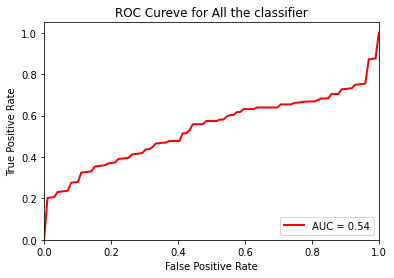

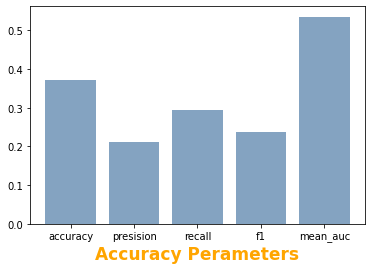

In [12]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(x)

gb = SVC(kernel='poly', probability=True)
df = Fit_Model(x, y,  gb, NoOfFolds=10)

### Feature selection and cross validation

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import numpy as np
import sklearn

clm = traningDF.drop(['class_label'], axis=1).columns


X_train = x
y_train = y 

model = ExtraTreesClassifier()
model.fit(X_train, y_train)

feat_importances = pd.Series(model.feature_importances_, index=clm)
fdf =  feat_importances.nlargest(5).to_frame()


TopFeatures  = fdf.reset_index()['index'].tolist()

                  
print (TopFeatures)

['PAAC12', 'PAAC7', 'PAAC2', 'PAAC11', 'PAAC10']


/Users/joshij/miniconda3/envs/p36/lib/python3.6/site-packages/ipykernel_launcher.py:70: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/joshij/miniconda3/envs/p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


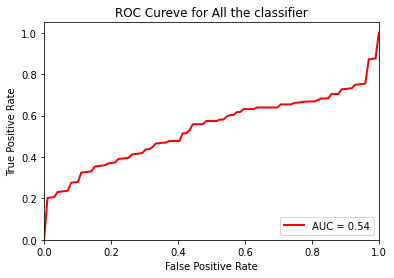

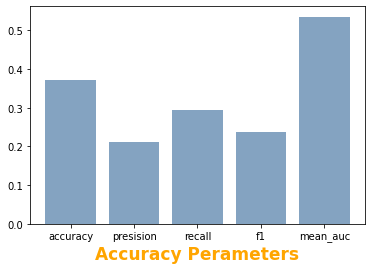

In [14]:
New_x = traningDF[TopFeatures].values
gb = SVC(kernel='poly', probability=True)
df = Fit_Model(x, y,  gb, NoOfFolds=10)

/Users/joshij/miniconda3/envs/p36/lib/python3.6/site-packages/ipykernel_launcher.py:70: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


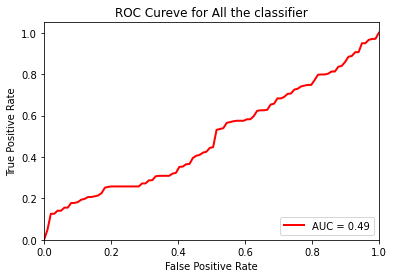

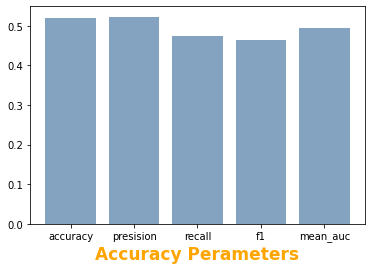

In [16]:
from sklearn.naive_bayes import GaussianNB
